In [1]:
using Distributions, LinearAlgebra, Plots, Random, LargeMessageCollider
Random.seed!(1234);

In [2]:
# Generate Synthetic Data
N = 50 # number of data points

p1, p2, p3 = Normal(-10.0, sqrt(1/0.25)), Normal(-3.0, sqrt(1/0.5)), Normal(7.5, sqrt(1/2))

real_mix = MixtureModel(Normal[p1,p2,p3], [0.2, 0.5, 0.3])

data = rand(real_mix, N);

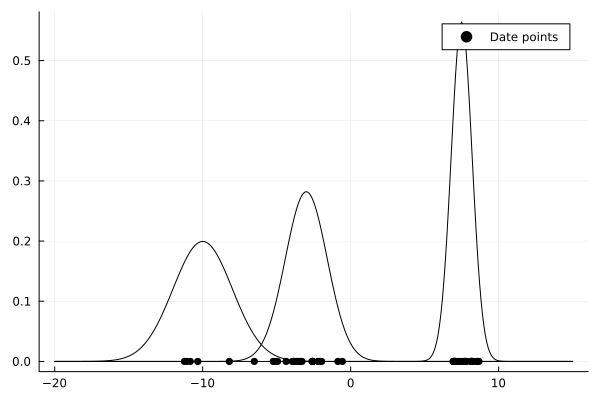

In [3]:
scatter(data,zeros(N), color=:black, label="Date points")
plot!(collect(-20:0.1:15), pdf.(p1,collect(-20:0.1:15)), color=:black, label=false)
plot!(collect(-20:0.1:15), pdf.(p2,collect(-20:0.1:15)), color=:black, label=false)
plot!(collect(-20:0.1:15), pdf.(p3,collect(-20:0.1:15)), color=:black, label=false)

In [4]:
# Priors
pm1, pm2, pm3 = Normal(mean(data)-std(data),10), Normal(mean(data),10), Normal(mean(data)+std(data),10)
pw1, pw2, pw3 = Gamma(1,1), Gamma(1,1), Gamma(1,1)
pϕ = Dirichlet([0.1,0.1,0.1])
;

In [5]:
# Initial recognition factors
qm = [pm1, pm2, pm3]
qw = [pw1, pw2, pw3]
qϕ = pϕ
qz = Array{Categorical}(undef,N)
for n=1:N
    qz[n] = Categorical(3)
end
;

In [6]:
# Inference
vmp = VMP() # a VMP instance to enable VMP message passing
for i=1:20
    # update qz
    for n=1:N
        back_m = normalmix(vmp,data[n],nothing,qm,qw)
        qz[n] = collide(categorical(vmp,nothing,qϕ),back_m)
    end

    # update qϕ
    categorical_vmp(a, b) = categorical(vmp, a, b) 
    back_m = categorical_vmp.(qz,nothing)
    qϕ = pϕ
    for n=1:N
        qϕ *= back_m[n]
    end

    # update qm
    qm = [pm1, pm2, pm3]
    for n=1:N
        back_m = normalmix(vmp,data[n],qz[n],nothing,qw)
        qm = collide.(qm, back_m)
    end

    # update qw
    qw = [pw1, pw2, pw3]
    for n=1:N
        back_m = normalmix(vmp,data[n],qz[n],qm,nothing)
        qw = collide.(qw, back_m)
    end

    # calculate Free Energy
    F = -entropy(qϕ) - sum(entropy.(qm)) - sum(entropy.(qw))
    F = F + cross_entropy(qϕ, pϕ) + sum(cross_entropy.(qm, [pm1, pm2, pm3])) + sum(cross_entropy.(qw, [pw1, pw2, pw3]))
    for n=1:N
        F -= entropy(qz[n])
        F += cross_entropy(qϕ, qz[n])
        F += normalmix(data[n],qz[n],qm,qw)
    end
    @show F
end

F = 146.08246998331967
F = 142.31281493630465
F = 141.77088914576086
F = 141.56557549578488
F = 141.4816624182594
F = 141.44552037587155
F = 141.42696485019727
F = 141.41194584622747
F = 141.3914548909194
F = 141.35603785928345
F = 141.29239676580568
F = 141.1814989020806
F = 140.99997021148442
F = 140.72815863026068
F = 140.36536504407036
F = 139.94163003282284
F = 139.50759139003725
F = 139.1035982883234
F = 138.73963282198244
F = 138.405249802334


In [7]:
qϕ

Dirichlet{Float64, Vector{Float64}, Float64}(alpha=[13.04562104030451, 13.156068527161583, 24.098310432533903])

In [8]:
qm

3-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=-6.301517730616474, σ=0.9526603177119938)
 Normal{Float64}(μ=-3.0321274556063966, σ=0.28477294391325714)
 Normal{Float64}(μ=7.680789670618896, σ=0.12853790397892442)

In [9]:
qw

3-element Vector{Gamma{Float64}}:
 Gamma{Float64}(α=7.4728105201522546, θ=0.011257947568237687)
 Gamma{Float64}(α=7.528034263580791, θ=0.11649579889153816)
 Gamma{Float64}(α=12.999155216266951, θ=0.1939858422687011)

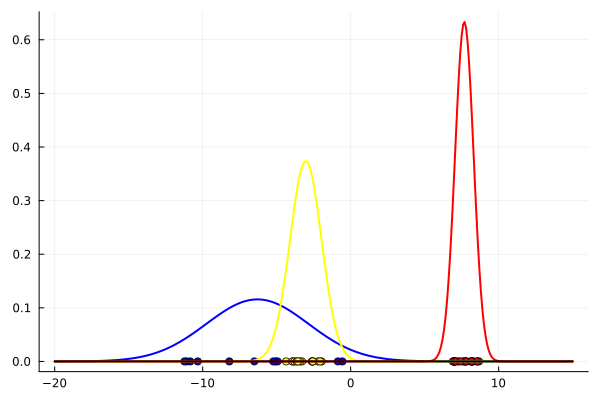

In [10]:
# Estimates
# We draw mixture distributions by using mean of approximate distributions

color_list = [:blue, :yellow, :red]
scatter((data[1],0),color=color_list[argmax(qz[1].p)], legend=false)
for n=2:N
    scatter!((data[n],0),color=color_list[argmax(qz[n].p)])
end
plot!(collect(-20:0.1:15),pdf.(Normal(mean(qm[1]),sqrt(1/mean(qw[1]))),collect(-20:0.1:15)), color=:blue,lw=2)
plot!(collect(-20:0.1:15),pdf.(Normal(mean(qm[2]),sqrt(1/mean(qw[2]))),collect(-20:0.1:15)), color=:yellow,lw=2)
plot!(collect(-20:0.1:15),pdf.(Normal(mean(qm[3]),sqrt(1/mean(qw[3]))),collect(-20:0.1:15)), color=:red,lw=2)
plot!(collect(-20:0.1:15),zeros(length(collect(-20:0.1:15))),color=:black, lw=2)